## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [56]:
import string
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [57]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [58]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = str()
MAX_LENGTH = 0
for line in text:
    out += line.lower()
    if len(line) > MAX_LENGTH:
        MAX_LENGTH = len(line)
text = out
print(MAX_LENGTH)

63


In [59]:
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [60]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [61]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
len(tokens)

38

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [62]:
# Your code here

from tqdm import tqdm
from IPython.display import clear_output
import torch, torch.nn as nn

num_tokens = len(tokens)

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=24, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True, num_layers=1)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_state):
        #print(x.data)
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_state = self.rnn(self.emb(x), h_state)
        logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(logits, dim=-1)
        return next_logp, h_state 

def to_matrix(text, batch_size=32, seq_len=None, dtype=torch.long):
    if not seq_len:
        seq_len = len(text) // batch_size
        
    matrix = []
    for i in range(0, seq_len * batch_size, seq_len):
        matrix.append([token_to_idx[c] for c in text[i:i+seq_len]])

    return torch.tensor(matrix, dtype=dtype)

In [63]:
model = CharRNNLoop()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())

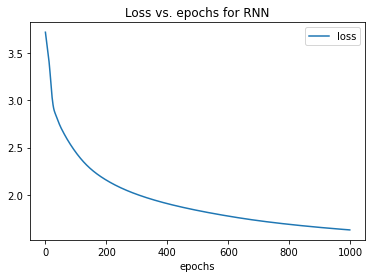

100%|███████████████████████████████████████| 1000/1000 [06:33<00:00,  2.54it/s]


In [64]:
from tqdm import tqdm
from IPython.display import clear_output
import torch, torch.nn as nn
import torch.nn.functional as F

batch_size = 32

batch_ix = to_matrix(text, batch_size)
history = []
for i in tqdm(range(1000)):
    h_state = torch.zeros(1, batch_size, 64)
    logp_seq, _ = model(batch_ix, h_state)
    

    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    # train with backprop
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    history.append(loss.item())
    
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.title('Loss vs. epochs for RNN')
        plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [65]:
def generate_text(model, length, seed_phrase='shall', temperature=1.0):
    model.eval()
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    
    hid_state = torch.zeros(1, 1, 64)
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(length - len(seed_phrase)):
        logp_next, hid_state = model(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0].ravel()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens),p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

print(generate_text(model, length=500, temperature=0.5))

shall show.
  the onterdering my hare the beauty be that and part be thy with searss the wain this in the with duth do the that the beauty the from be makes the so thou sumpincter self at thine shown the arthest in prest so fory be that the beauty self thou dear doth be some thou prose of this of me thou so praise beauty say with one thou mine,
  the pood the were the warly have in the rest the fair, which are thou love the ward a see on the cordave a prides be of the with thou hangs that sun th


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

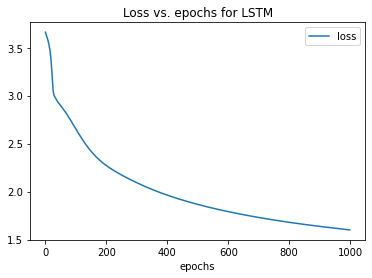

100%|███████████████████████████████████████| 1000/1000 [17:00<00:00,  1.02s/it]


In [66]:
num_tokens = len(tokens)
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=24, lstm_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, lstm_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(lstm_num_units, num_tokens)
        
    def forward(self, x, h_n, c_n):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, (h_n, c_n) = self.lstm(self.emb(x), (h_n, c_n))
        logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(logits, dim=-1)
        return next_logp, (h_n, c_n)
    
model_lstm = CharLSTMLoop()
criterion = nn.NLLLoss()
opt_lstm = torch.optim.Adam(model_lstm.parameters())

history_lstm = []
for i in tqdm(range(1000)):
    (h_init, c_init) = (torch.zeros(1, batch_size, 64),
                        torch.zeros(1, batch_size, 64))
    logp_seq, _ = model_lstm(batch_ix, h_init, c_init)
    

    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    # train with backprop
    opt_lstm.zero_grad()
    loss.backward()
    opt_lstm.step()
    
    history_lstm.append(loss.item())
    
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history_lstm,label='loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.title('Loss vs. epochs for LSTM')
        plt.show()

In [69]:
print(f'The score for LSTM is {history_lstm[-1]}, for RNN - {history[-1]} which is only 3% better in our case but the gap might get bigger during futher training or on a bigger dataset.')

The score for LSTM is 1.6001806259155273, for RNN - 1.630288004875183 which is only 3% better in our case but the gap might get bigger during futher training or on a bigger dataset.


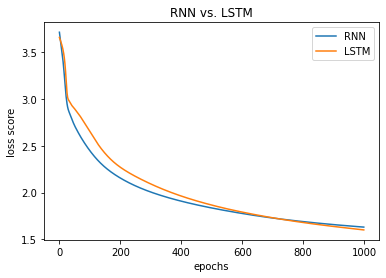

In [70]:
plt.plot(history, label='RNN')
plt.plot(history_lstm, label='LSTM')
plt.title('RNN vs. LSTM')
plt.xlabel('epochs')
plt.ylabel('loss score')
plt.legend()
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [73]:
def generate_text_lstm(model, length, seed_phrase='shall', temperature=1.0):
    model.eval()
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    
    (h_state, c_state) = (torch.zeros(1, 1, 64),
                        torch.zeros(1, 1, 64))
    for i in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = model(x_sequence[:, :, i], h_state, c_state)
    
    #start generating
    for _ in range(length - len(seed_phrase)):
        logp_next, (h_state, c_state) = model(x_sequence[:, :, -1], h_state, c_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0].ravel()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens),p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [74]:
# Text generation with different temperature values here
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(generate_text_lstm(model_lstm, length=500, temperature=t))
    print(f'=-=-=-=-=-=-=-=-Temperature is {t}-=-=-=-=-=-=-=-=-=-=-=-')

shall thee the stand the stand the stand the stand the strange,
  and the stand the stand the still the stand the see the stand the stand the stand the stand the stand the stand in the see the stand the stand the stand the stand the stand the stand the stand the stand the stand the strange,
  and the see the stand the stand the stand the stand the stand the stand the stand the stand the stand the see the stand the stand the stand the stand the stand the stand the stand the stand the stare with t
=-=-=-=-=-=-=-=-Temperature is 0.1-=-=-=-=-=-=-=-=-=-=-=-
shalled thee and the stare the strange,
  and the stand the praise the stand thee my sunce is the shall the stand,
    be the self thee thee the still the stand,
  and the the see the strange,
  and the stare my stange the strains the will the strange,
  and the see the stare my love the strange the still the stand in the beauty in me thee the still the stand thee in the then the shall and the seep thee the strange,
  the so the then the

Greater the temperature, more mess is being generated by the network, which is pretty intuitive, as long as for the low temperatures it keeps repeating itself. Might a just a personal opinion, but the temperature `0.5` seems to be just fine and the most appropriate.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [75]:
torch.save(model_lstm.state_dict(), 'CharLSTMLoop.pt')
model = CharLSTMLoop()
model.load_state_dict(torch.load('CharLSTMLoop.pt'))
model.eval()

print(generate_text_lstm(model, length=500, temperature=0.5))

shalleves, and say deart's dear shall should of thou bear to the have the still of my love the shall i do will the then deporn and wheres in his beauty made cononed no loving beauty bear dear i do gavent to thy so fart of the stand shall a searth so thee mine is your some, is the shall they thy show in the love are in me of a sinder thee worth to not beauty thy misert,
    proul the sain the sit me her thy death that i thee to thou main not beauty be my every seal thee of thine eyes my shall tha


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)